In [2]:
import scipy
import scipy.ndimage
from scipy.cluster.vq import vq, kmeans, whiten
from scipy import misc

import numpy as np
import time
import matplotlib.pyplot as plt
import imageio
import PIL as pil
import pickle
import math as mt

### Lectura y visualización de una imagen

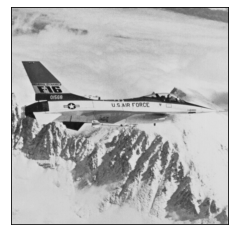

[[193 185 178 ... 165 164 147]
 [191 195 194 ... 178 156 139]
 [193 197 194 ... 190 156 140]
 ...
 [215 212 208 ... 205 208 212]
 [217 211 208 ... 192 188 191]
 [213 211 211 ... 184 176 149]]


In [3]:
imagen=imageio.imread('../standard_test_images/jetplane.png')

(n,m)=imagen.shape # filas y columnas de la imagen

plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(imagen, cmap=plt.cm.gray,vmin=0, vmax=255)
plt.show()
print(imagen)

# Cuantización escalar

**Definid una función** `Cuantizacion_uniforme_adaptativa(imagen, bits=3, n_bloque=8)`
    **que dada una imagen cuantize uniformemente los valores en cada bloque.**

```
imagen: imagen a cuantizar
bits: número de bits necesarios para cuantizar cada bloque, 
      o sea que en cada bloque habrá 2**bits valores diferentes 
      como máximo
n_bloque: se consideran bloques de tamaño n_bloque*n_bloque 

imagenCodigo: es una lista de la forma
[[n,m,n_bloque,bits],[[minimo,maximo],bloqueCodificado],...,[[minimo,maximo],bloqueCodificado]]

siendo:
[n,m,n_bloque,bits] información de la imagen
  n: número de filas de la imagen
  m: número de columnas de la imagen
  n_bloque: tamaño de los bloques usados (divisor de n y m)
  bits: número de bits necesarios para codificar los 
        niveles de recontrucción.
Ejemplo: [1024, 1024, 8, 3]

[[minimo,maximo],bloqueCodificado] información de cada bloque codificado
  minimo: valor mínimo del bloque
  maximo: valor máximo del bloque
  bloqueCodificado: array de tamaño n_bloque*n_bloque que contiene 
       en cada posición a que intervalo de cuantización correspondía 
       el valor del píxel correspondiente en la imagen

Ejemplo: sabemos que trabajamos con bloques 8x8 y que hemos cuantizado en 2**3=8 niveles
    [[85, 150], 
    Array([[4, 0, 0, 4, 7, 7, 6, 7], 
           [4, 3, 1, 1, 4, 7, 7, 6],
           [6, 6, 3, 0, 0, 4, 6, 6], 
           [6, 6, 5, 3, 1, 0, 3, 6],
           [6, 5, 6, 6, 4, 0, 0, 3],
           [5, 6, 6, 6, 6, 4, 2, 0],
           [6, 6, 5, 5, 6, 7, 4, 1],
           [6, 6, 5, 5, 5, 6, 6, 5]]  
   El valor mínimo de los píxeles del bloque era 85 y el máximo 150, por lo 
   tanto los límites de decisión son:
       [85.0, 93.25, 101.5, 109.75, 118.0, 126.25, 134.5, 142.75, 151.0]
   el valor del primer pixel (4) estaría entre 109.75<=p<118
   el valor del segundo pixel pixel (0) estaría entre 85<=p<93.25...
   
      
Importante: Trabajar con Arrays de Numpy

``` 


In [5]:
def dividir(array, n_rows_blocks=8, n_cols_blocks=8):
    r, c = array.shape
    b = (array.reshape(c // n_rows_blocks, n_rows_blocks, -1, n_cols_blocks).swapaxes(1, 2).reshape(-1, n_rows_blocks, n_cols_blocks).swapaxes(1, 2))
    return b


def reconstruir(bloques):
    a, b, c = bloques.shape
    n_bloques = b*c
    new_im = np.concatenate(bloques[0:n_bloques])
    i = n_bloques
    while i < len(bloques):
        new_im = np.concatenate((new_im, np.concatenate(bloques[i:i+n_bloques])), axis=1)
        i += n_bloques
    return np.transpose(new_im)


def cuantizar_minimo_maximo(bloque, k):
    minimo = np.min(bloque)
    maximo = np.max(bloque)
    delta = (maximo - minimo)/(2**k)
    bloque = np.round(((bloque - minimo)//delta + 1/2)*delta + minimo) 
    return bloque


def Cuantizacion_uniforme_adaptativa(imagen, bits=3, n_bloque=8):
    bloques = dividir(imagen, n_bloque, n_bloque)
    new_bloques = bloques.copy()
    for index, bloque in enumerate(bloques):
        new_bloques[index] = cuantizar_minimo_maximo(bloque, k)
#     new_im = reconstruir(new_bloques)
#     return new_im
    return imagenCodigo




**Definid una función** `Dibuja_imagen_cuantizada(imagenCodigo)`
    **que dada una imagen codificada por la función** 
`Cuantizacion_uniforme_adaptativa` **muestre la imagen.**


In [11]:
def descuantizar_bloque(bloque, k):
    [minimo, maximo] = bloque[0]
    inter = np.linspace(minimo, maximo, (2**k)+1)
    new_bloque = []
#     print(bloque[1])
    for row in bloque[1]:
        new_row = []
        for x in row:
            m = int((inter[x] + inter[x+1])//2)
            new_row.append(m)
        new_bloque += [new_row]
    return new_bloque
        


def Dibuja_imagen_cuantizada(imagenCodigo):
    [n,m,n_bloque, k] = imagenCodigo[0]
    ilim = n//n_bloque
    jlim = m//n_bloque
    imagen = np.empty((1,m))
    count = 1
    for i in range(0, ilim):
        c_aux = count
        for i in range(0, n_bloque):
            count = c_aux
            row = np.array([])
            for j in range(0, jlim):
                new_bloque = descuantizar_bloque(imagenCodigo[count], k)
                row = np.append(row, new_bloque[i], axis = 0)
                count += 1
            imagen = np.append(imagen, [row], axis = 0)
    imagen = np.delete(imagen, 0, axis = 0)
    plt.figure()
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imagen, cmap=plt.cm.gray,vmin=0, vmax=255)
    plt.show()
    return imagen




# Preguntas Cuestionario

## Cuantizar bloque
#### a veces saca numeros que no debe, pero de las tres opciones, cojes la que tenga numeros menores a 2 ^ numero de bits, se puede sacar a ojo

In [9]:
def cuantizar_bloque(bloque, k):
    minimo = np.min(bloque)
    maximo = np.max(bloque)
    delta = (maximo-minimo)/(2**k)
    inter = np.delete((np.linspace(minimo, maximo, (2**k) + 1)), -1)
    new_bloque = [[minimo, maximo]]
    for row in bloque:
        new_row = np.digitize(row, inter)
        new_row -= 1
        new_bloque.append(new_row.tolist())
    return new_bloque

bloque = [[64, 69, 95, 95, 95, 100, 91, 50], [64, 78, 95, 89, 92, 84, 60, 55], [60, 82, 92, 88, 80, 58, 55, 79], [56, 86, 93, 76, 59, 71, 84, 76], [59, 82, 71, 62, 72, 91, 70, 58], [54, 67, 73, 68, 85, 84, 53, 52], [64, 86, 80, 95, 94, 65, 55, 42], [68, 88, 80, 91, 76, 50, 44, 49]]
k = 4
bloque_cuantizado = cuantizar_bloque(bloque, k)
print(bloque_cuantizado)

[[42, 100], [6, 7, 14, 14, 14, 15, 13, 2], [6, 9, 14, 12, 13, 11, 4, 3], [4, 11, 13, 12, 10, 4, 3, 10], [3, 12, 14, 9, 4, 8, 11, 9], [4, 11, 8, 5, 8, 13, 7, 4], [3, 6, 8, 7, 11, 11, 3, 2], [6, 12, 10, 14, 14, 6, 3, 0], [7, 12, 10, 13, 9, 2, 0, 1]]


## Pregunta 2: Calculo de bits por pixel
#### sustituyes según tus datos y lo sacas

In [23]:
grises_escalar = 16 #Escala de grises de los bloques
blockSize = 16 #tamaño del bloque, si es 8 x 8, pues 8
bits_pixel = (16/(blockSize*blockSize))+mt.log(grises_escalar, 2)
print(bits_pixel)

4.0625


In [24]:
rows = 3072  #rows de la imgen
cols = 10240  #cols de la imagen
blockSize = 16  #tamaño del bloque, si es 8 x 8, pues 8
entradas = 64 #numero de entradas del diccionario
numBlocks = (rows * cols) / (blockSize ** 2)
encodedImageSize = numBlocks * mt.ceil(mt.log(entradas, 2))
dictSize = entradas * (blockSize**2) * 8
recoveredImageSize = encodedImageSize + dictSize
print(recoveredImageSize / (rows * cols))

0.027604166666666666


## Pregunta 3: recuperar imagen para numero en cuantización escalar
#### importante descargar la imagen con nombre imagencodificada.py

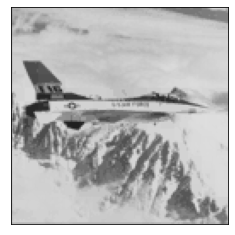

array([[166., 189., 189., ..., 195., 195., 184.],
       [160., 177., 177., ..., 206., 184., 184.],
       [160., 171., 166., ..., 184., 162., 173.],
       ...,
       [187., 204., 210., ..., 118., 131., 171.],
       [193., 210., 210., ..., 131., 158., 184.],
       [170., 187., 187., ..., 131., 145., 158.]])

In [22]:
with open("imagencodificada.py", 'rb') as file:
    imagenLeidaCodificada=pickle.load(file)
Dibuja_imagen_cuantizada(imagenLeidaCodificada)

## Pregunta 4: recuperar imagen para numero en cuantización vectorial
#### importante descargar la imagen con nombre imagencodificada2.py

[512, 512, 16]
(rows, cols, block_size) =  512 512 16
Blocks 1024


array([[232., 232., 232., ..., 209., 209., 208.],
       [232., 232., 232., ..., 209., 209., 207.],
       [231., 231., 232., ..., 206., 206., 205.],
       ...,
       [117., 117., 118., ...,  93.,  88.,  82.],
       [118., 119., 119., ...,  97.,  91.,  85.],
       [118., 119., 118., ..., 102., 102.,  97.]])

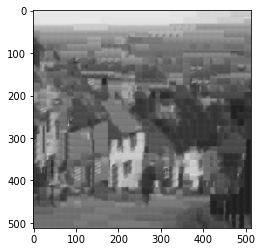

In [25]:
with open("imagencodificada2.py", 'rb') as file:
    imagenLeidaCodificada=pickle.load(file)
Dibuja_imagen_cuantizada_KMeans(imagenLeidaCodificada)

In [248]:
inter = np.linspace(0,50,4)
print(inter)
print(np.digitize([2, 12.5, 30, 8, 50], inter)-1)

[ 0.         16.66666667 33.33333333 50.        ]
[0 0 1 0 3]



Aplicad vuestras funciones a las imágenes que encontraréis en Atena y haced una estimación de la ratio de compresión.



In [154]:
buit = np.empty((1,4), int)
print(buit)
# buit = np.append(buit, [])
extend = np.append(buit, [[1, 2, 3, 4]], axis = 0)
print(extend)
extend = np.delete(extend, 0,)

[[1 2 3 4]]
[[1 2 3 4]
 [1 2 3 4]]
[[1 2 3 4]]


**Definid una funcion** `Cuantizacion_vectorial_KMeans(imagen, entradas_diccionario=2**8, n_bloque=8)` **que dada una imagen
la cuantize vectorialmente usando K-means.**

``` 
imagen: imagen a cuantizar
entradas_diccionario: número máximo de entradas del diccionario 
       usado para codificar.
n_bloque: Las entradas del diccionario serán bloques de la imagen 
       de tamaño n_bloque*n_bloque 

imagenCodigo: es una lista de la forma
[[n,m,n_bloque],Diccionario,indices]

siendo:
[n,m,n_bloque] información de la imagen
  n: número de filas de la imagen
  m: número de columnas de la imagen
  n_bloque: tamaño de los bloques usados (divisor de n y m)
Ejemplo: [1024, 1024, 8]

Diccionario: lista de arrays cuyos elementos son bloques de la 
     imagen que se usan como diccionario para cuantizar 
     vectorialmente la imagen.
Ejemplo:
    [
    array([[173, 172, 172, 171, 171, 171, 171, 172],
       [173, 172, 172, 172, 171, 171, 171, 171],
       [172, 172, 172, 172, 171, 171, 170, 170],
       [172, 172, 171, 171, 171, 171, 170, 169],
       [172, 171, 171, 171, 171, 171, 170, 169],
       [171, 171, 170, 170, 170, 170, 170, 169],
       [171, 171, 170, 170, 170, 170, 169, 169],
       [171, 171, 171, 170, 170, 169, 169, 169]], dtype=uint8), 
    array([[132, 131, 128, 122, 118, 117, 121, 124],
       [129, 132, 132, 128, 122, 119, 118, 119],
       [122, 128, 133, 133, 128, 123, 119, 116],
       [115, 121, 128, 131, 132, 130, 124, 119],
       [114, 117, 122, 126, 131, 134, 131, 126],
       [109, 114, 118, 122, 127, 133, 135, 132],
       [ 91, 102, 113, 117, 121, 127, 132, 133],
       [ 70,  89, 107, 114, 115, 120, 127, 131]], dtype=uint8)
...]

indices: array que contiene los índices de los elementos del diccionario 
    por los que hay que sustituir los bloques de la imagen.
Ejemplo: array([14, 124, 22, ...,55, 55, 356], dtype=int32)]  
    Al reconstruir la imagen el primer bloque se sustituirá por el bloque 14 
    del diccionario, el segundo se sustituirá por el bloque 124 del 
    diccionario,..., el último se substituirá por el bloque 356 del 
    diccionario.
        
      
Importante: Trabajar con Arrays de Numpy

```



# Cuantización vectorial


IMPORTANTE: K-means clustering and vector quantization 

http://docs.scipy.org/doc/scipy/reference/cluster.vq.html

Usad las funciones implementadas, en particular vq y kmeans



In [ ]:
def Cuantizacion_vectorial_KMeans(imagen, entradas_diccionario=2**8, n_bloque=8):
    
    return imagenCodigo




**Definid una función** `Dibuja_imagen_cuantizada_KMeans(imagenCodigo)`  **que dada una imagen codificada por la función** 
`Cuantizacion_vectorial_KMeans()` **muestre la imagen codificada.**



In [13]:
def Dibuja_imagen_cuantizada_KMeans(image_coded):
    metadata = image_coded[0]
    print(metadata)
    rows, cols, block_size = metadata
    print('(rows, cols, block_size) = ', rows, cols, block_size)
    blocks = image_coded[1]
    indices = image_coded[2]
    decoded_blocks = np.zeros((rows, cols))
    n_blocks = len(indices)

    print('Blocks', n_blocks)
    row = 0
    col = 0
    a = 0
    for i in range(n_blocks):
        decoded_blocks[row:block_size + row, col:block_size + col] = blocks[indices[i]]

        col += block_size
        if col >= cols:
            col = 0
            row += block_size
    plt.imshow(decoded_blocks, cmap=plt.cm.gray,vmin=0, vmax=255)
    return decoded_blocks


Aplicad vuestras funciones a las imágenes que encontraréis en Atena y haced una estimación de la ratio de compresión.


# Algunas sugerencias que pueden ser útiles

Divido todos los píxeles de la imagen por $q$;

a continuación redondeo todos los píxeles;

a continuación sumo $\frac{1}{2}$ a todos los píxeles de la imagen;

a continuación convierto los valores de todos los píxeles en enteros de 8 bits sin signo;

por último múltiplico todos los píxeles de la imagen por $q$.


In [3]:
bits=3
q=2**(bits) 
imagen2=((np.floor(imagen/q)+1/2).astype(np.uint8))*q

dibujo la imagen cuanzizada resultante

In [3]:
fig=plt.figure()
fig.suptitle('Bloques: '+str(bits)+' bits/píxel')
plt.xticks([])
plt.yticks([])
plt.imshow(imagen2, cmap=plt.cm.gray,vmin=0, vmax=255) 
plt.show()

Lectura y escritura de objetos

In [3]:
import pickle

fichero='QScalar'

with  open(fichero+'_dump.pickle', 'wb') as file:
    pickle.dump(imagenCodigo, file)


with open(fichero, 'rb') as file:
    imagenLeidaCodificada=pickle.load(file)

Convertir un array en imagen, mostrarla y guardarla en formato png.

La calidad por defecto con que el ecosistema python (ipython, jupyter,...) muestra las imágenes no hace justicia ni a las imágenes originales ni a las obtenidas tras la cuantización.     


In [5]:
import PIL

imagenPIL=PIL.Image.fromarray(imagen)
imagenPIL.show()
imagenPIL.save('imagen.png', 'PNG')